# Optimization Intuition: From Calculus to Neural Networks

## 1. Introduction to Optimization

Optimization is the mathematical engine of machine learning. At its core, it is the process of finding the input parameters $\mathbf{x}$ that minimize (or maximize) an objective function $f(\mathbf{x})$.

In deep learning, $f(\mathbf{x})$ is typically a **loss function** $\mathcal{L}(\theta)$, where $\theta$ represents the weights of a neural network. We seek:

$$ \theta^* = \underset{\theta}{\text{argmin }} \mathcal{L}(\theta) $$

### The Gradient Vector

For a scalar function $f: \mathbb{R}^n \to \mathbb{R}$, the gradient vector $\nabla f(\mathbf{x})$ is the collection of all partial derivatives:

$$ \nabla f(\mathbf{x}) = \begin{bmatrix} \frac{\partial f}{\partial x_1} \\ \frac{\partial f}{\partial x_2} \\ \vdots \\ \frac{\partial f}{\partial x_n} \end{bmatrix} $$

The gradient points in the direction of steepest **ascent**. Therefore, to minimize a function, we move in the direction of the negative gradient: $-\nabla f(\mathbf{x})$.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.optimize import minimize
import warnings

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context("notebook", font_scale=1.2)
warnings.filterwarnings('ignore')
np.random.seed(42)

print("Environment configured.")

Environment configured.


## 2. Convexity and Curvature

The difficulty of an optimization problem is largely determined by the **curvature** of the loss landscape.

### The Hessian Matrix
While the gradient tells us the slope (first derivative), the **Hessian matrix** tells us the curvature (second derivative). For a function $f(\mathbf{x})$:

$$ \mathbf{H} = \nabla^2 f(\mathbf{x})_{ij} = \frac{\partial^2 f}{\partial x_i \partial x_j} $$

- **Convex Functions**: The Hessian is positive semi-definite everywhere (all eigenvalues $\ge 0$). Any local minimum is a global minimum.
- **Non-Convex Functions**: The Hessian has mixed or negative eigenvalues in some regions. This leads to local minima, saddle points, and plateaus.

Deep learning loss landscapes are highly non-convex.

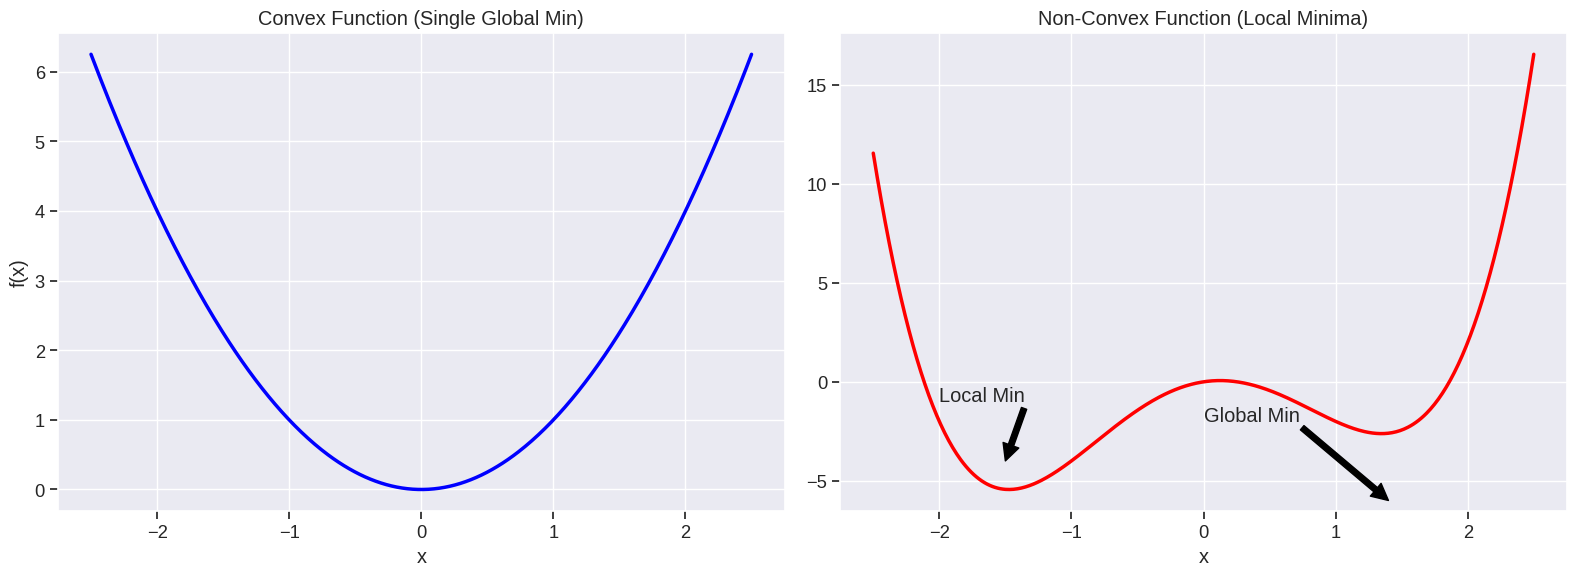

In [26]:
def convex_function(x): 
    return x**2

def non_convex_function(x): 
    return x**4 - 4*x**2 + x

x = np.linspace(-2.5, 2.5, 500)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Convex Plot
axes[0].plot(x, convex_function(x), 'b-', linewidth=2.5)
axes[0].set_title("Convex Function (Single Global Min)")
axes[0].set_xlabel("x")
axes[0].set_ylabel("f(x)")

# Non-Convex Plot
axes[1].plot(x, non_convex_function(x), 'r-', linewidth=2.5)
axes[1].set_title("Non-Convex Function (Local Minima)")
axes[1].set_xlabel("x")
axes[1].annotate('Local Min', xy=(-1.5, -4), xytext=(-2, -1), arrowprops=dict(facecolor='black'))
axes[1].annotate('Global Min', xy=(1.4, -6), xytext=(0, -2), arrowprops=dict(facecolor='black'))

plt.tight_layout()
plt.show()

## 3. Gradient Descent Variants

Standard Gradient Descent updates parameters using the gradient of the *entire* dataset. In practice, this is computationally expensive and redundant.

### Stochastic Gradient Descent (SGD)
Instead of computing the exact gradient, SGD estimates it using a **single random sample**.

$$ \theta_{t+1} = \theta_t - \eta \nabla \mathcal{L}_i(\theta_t) $$

- **Pros**: Extremely fast updates, escapes local minima due to noise.
- **Cons**: High variance, noisy convergence path.

### Mini-Batch Gradient Descent
The standard approach in deep learning. Computes the gradient over a small batch (e.g., 32, 64 samples).

- **Balance**: Reduces variance compared to SGD, exploits vectorization better than SGD.

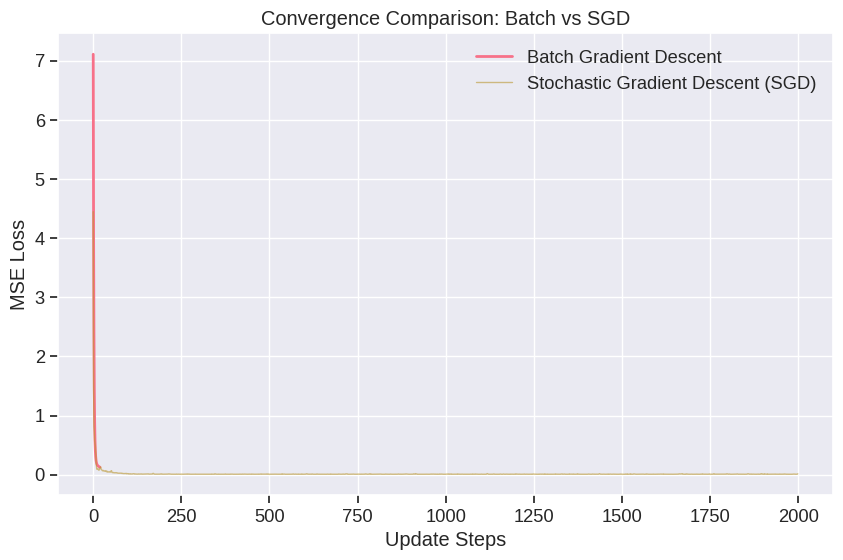

In [27]:
def generate_linear_data(n=100, noise=0.1):
    X = np.random.rand(n, 1)
    y = 3 * X + 2 + noise * np.random.randn(n, 1)
    return X, y

X, y = generate_linear_data()

# Gradient Descent Implementation
def gradient_descent(X, y, lr=0.1, epochs=50, batch_size=None):
    n, d = X.shape
    w = np.zeros((d, 1))
    b = 0
    path = []
    
    if batch_size is None:
        batch_size = n
        
    for _ in range(epochs):
        indices = np.random.permutation(n)
        X_shuff, y_shuff = X[indices], y[indices]
        
        for i in range(0, n, batch_size):
            Xi = X_shuff[i:i+batch_size]
            yi = y_shuff[i:i+batch_size]
            
            # Prediction
            y_pred = np.dot(Xi, w) + b
            
            # Gradients
            dw = -2 * np.mean(Xi * (yi - y_pred))
            db = -2 * np.mean(yi - y_pred)
            
            # Update
            w -= lr * dw
            b -= lr * db
            
            path.append(np.mean((y - (np.dot(X, w) + b))**2)) # MSE Loss
            
    return path

path_batch = gradient_descent(X, y, lr=0.1, epochs=20, batch_size=None)
path_sgd = gradient_descent(X, y, lr=0.1, epochs=20, batch_size=1)

plt.figure(figsize=(10, 6))
plt.plot(path_batch, label='Batch Gradient Descent', linewidth=2)
plt.plot(path_sgd, label='Stochastic Gradient Descent (SGD)', alpha=0.6, linewidth=1)
plt.xlabel("Update Steps")
plt.ylabel("MSE Loss")
plt.title("Convergence Comparison: Batch vs SGD")
plt.legend()
plt.grid(True)
plt.show()

## 4. Advanced Adaptive Optimizers

Standard SGD has trouble navigating ravines (areas where the surface curves much more steeply in one dimension than in another). Adaptive methods address this.

### Momentum
Momentum accumulates a velocity vector $\mathbf{v}_t$ to dampen oscillations and accelerate in relevant directions.

$$ 
\mathbf{v}_{t+1} = \beta \mathbf{v}_t + (1 - \beta) \nabla \mathcal{L}(\theta_t) \\
\theta_{t+1} = \theta_t - \eta \mathbf{v}_{t+1}
$$

### RMSProp (Root Mean Square Propagation)
RMSProp divides the learning rate by an exponentially decaying average of squared gradients. This normalizes gradient magnitudes, handling non-stationary objectives effectively.

$$ 
\mathbf{s}_{t+1} = \gamma \mathbf{s}_t + (1 - \gamma) (\nabla \mathcal{L}(\theta_t))^2 \\
\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\mathbf{s}_{t+1} + \epsilon}} \nabla \mathcal{L}(\theta_t)
$$

### Adam (Adaptive Moment Estimation)
Adam combines Momentum (first moment) and RMSProp (second moment). It is the default optimizer for most deep learning tasks today.

1.  **First Moment (Mean):** $\mathbf{m}_t = \beta_1 \mathbf{m}_{t-1} + (1 - \beta_1) \mathbf{g}_t$
2.  **Second Moment (Variance):** $\mathbf{v}_t = \beta_2 \mathbf{v}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2$
3.  **Bias Correction:** $\hat{\mathbf{m}}_t = \mathbf{m}_t / (1 - \beta_1^t), \quad \hat{\mathbf{v}}_t = \mathbf{v}_t / (1 - \beta_2^t)$
4.  **Update:** $\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{\mathbf{v}}_t} + \epsilon} \hat{\mathbf{m}}_t$

In [28]:
# Implementation of Optimizers from Scratch

class Optimizer:
    def update(self, params, grads):
        raise NotImplementedError

class SGD(Optimizer):
    def __init__(self, lr=0.01):
        self.lr = lr
    def update(self, params, grads):
        return params - self.lr * grads

class Momentum(Optimizer):
    def __init__(self, lr=0.01, beta=0.9):
        self.lr = lr
        self.beta = beta
        self.v = None
    def update(self, params, grads):
        if self.v is None: self.v = np.zeros_like(params)
        self.v = self.beta * self.v + (1 - self.beta) * grads
        return params - self.lr * self.v

class RMSProp(Optimizer):
    def __init__(self, lr=0.01, gamma=0.9, eps=1e-8):
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.s = None
    def update(self, params, grads):
        if self.s is None: self.s = np.zeros_like(params)
        self.s = self.gamma * self.s + (1 - self.gamma) * (grads**2)
        return params - self.lr * grads / (np.sqrt(self.s) + self.eps)

class Adam(Optimizer):
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, eps=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = None
        self.v = None
        self.t = 0
    def update(self, params, grads):
        if self.m is None: 
            self.m = np.zeros_like(params)
            self.v = np.zeros_like(params)
        self.t += 1
        
        self.m = self.beta1 * self.m + (1 - self.beta1) * grads
        self.v = self.beta2 * self.v + (1 - self.beta2) * (grads**2)
        
        m_hat = self.m / (1 - self.beta1**self.t)
        v_hat = self.v / (1 - self.beta2**self.t)
        
        return params - self.lr * m_hat / (np.sqrt(v_hat) + self.eps)

## 5. Visualizing Optimizer Trajectories

We will visualize how different optimizers navigate a complex loss landscape. We'll use the **Beale Function**, a classic test function for optimization algorithms.

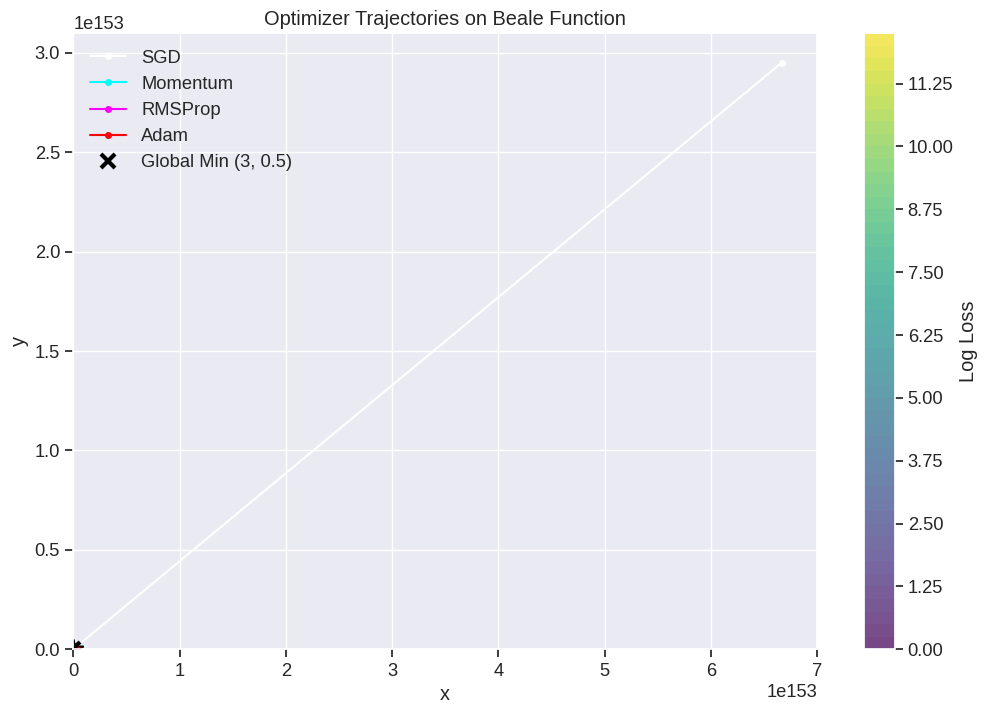

In [29]:
def beale_function(x, y):
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

def beale_grads(x, y):
    # Partial derivatives (computed analytically for efficiency)
    # df/dx
    df_dx = 2*(1.5 - x + x*y)*(-1 + y) + 2*(2.25 - x + x*y**2)*(-1 + y**2) + 2*(2.625 - x + x*y**3)*(-1 + y**3)
    # df/dy
    df_dy = 2*(1.5 - x + x*y)*(x) + 2*(2.25 - x + x*y**2)*(2*x*y) + 2*(2.625 - x + x*y**3)*(3*x*y**2)
    return np.array([df_dx, df_dy])

def optimize_trajectory(optimizer, start_pos, steps=100):
    path = [start_pos]
    params = np.array(start_pos)
    for _ in range(steps):
        grads = beale_grads(params[0], params[1])
        params = optimizer.update(params, grads)
        path.append(params)
    return np.array(path)

# Setup
start_pos = [3.0, 3.0] # Starting far from minimum
opts = {
    "SGD": SGD(lr=0.001),
    "Momentum": Momentum(lr=0.001, beta=0.9),
    "RMSProp": RMSProp(lr=0.01),
    "Adam": Adam(lr=0.05)
}

# Compute Paths
paths = {name: optimize_trajectory(opt, start_pos) for name, opt in opts.items()}

# Plotting
x = np.linspace(-4.5, 4.5, 200)
y = np.linspace(-4.5, 4.5, 200)
X, Y = np.meshgrid(x, y)
Z = beale_function(X, Y)
Z = np.log(Z + 1) # Log scale for better visualization

plt.figure(figsize=(12, 8))
plt.contourf(X, Y, Z, levels=50, cmap='viridis', alpha=0.7)
plt.colorbar(label='Log Loss')

colors = ['white', 'cyan', 'magenta', 'red']
for (name, path), color in zip(paths.items(), colors):
    plt.plot(path[:, 0], path[:, 1], 'o-', label=name, color=color, markersize=4, linewidth=1.5)
    plt.plot(path[-1, 0], path[-1, 1], '*', color=color, markersize=15, markeredgecolor='black') # End point

plt.plot([3], [0.5], 'kx', markersize=10, markeredgewidth=3, label='Global Min (3, 0.5)')
plt.title("Optimizer Trajectories on Beale Function")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## 6. Learning Rate Decay

A constant learning rate is often suboptimal. 
- **High LR**: Fast initial convergence but oscillates near minimum.
- **Low LR**: Clean convergence but takes forever.

**Decay schedules** give us the best of both worlds: start fast, then slow down for fine-tuning.

$$ \eta_t = \eta_0 \cdot \gamma^{\text{epoch}} $$

The plot below visualizes exponential decay.

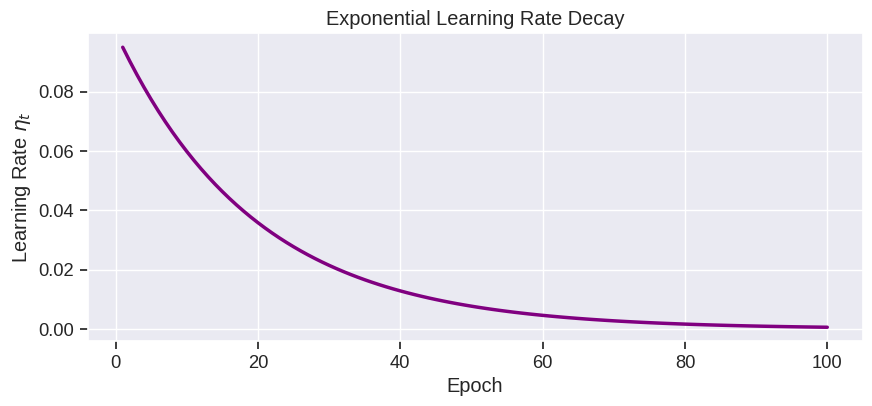

In [30]:
def exponential_decay(lr0, epoch, decay_rate=0.95):
    return lr0 * (decay_rate ** epoch)

epochs = np.arange(1, 101)
lrs = [exponential_decay(0.1, e) for e in epochs]

plt.figure(figsize=(10, 4))
plt.plot(epochs, lrs, 'purple', linewidth=2.5)
plt.title("Exponential Learning Rate Decay")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate $\eta_t$")
plt.grid(True)
plt.show()

## 7. Practical Application: Training a Neural Network

Finally, let's put it all together. We will implement a simple 2-layer Neural Network from scratch (using NumPy) to classify a non-linear dataset (XOR problem).

We will confirm that **Adam** converges faster than standard **SGD**.

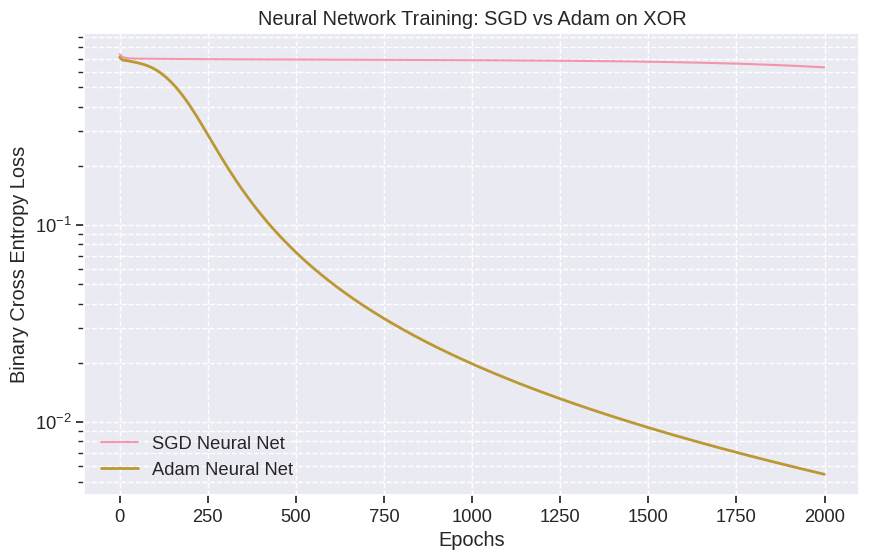

In [31]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

# Create XOR Dataset
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [1], [1], [0]])

class SimpleNN:
    def __init__(self, input_size, hidden_size, output_size):
        # Xavier Initialization
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1/input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1/hidden_size)
        self.b2 = np.zeros((1, output_size))
        
    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = sigmoid(self.z2)
        return self.a2
    
    def backward(self, X, y, output):
        m = X.shape[0]
        
        # Gradients
        dz2 = output - y
        dW2 = (1/m) * np.dot(self.a1.T, dz2)
        db2 = (1/m) * np.sum(dz2, axis=0, keepdims=True)
        
        dz1 = np.dot(dz2, self.W2.T) * sigmoid_derivative(self.z1)
        dW1 = (1/m) * np.dot(X.T, dz1)
        db1 = (1/m) * np.sum(dz1, axis=0, keepdims=True)
        
        return {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2}
    
    def get_params(self):
        return np.concatenate([self.W1.ravel(), self.b1.ravel(), self.W2.ravel(), self.b2.ravel()])
    
    def set_params(self, params):
        # This helper function is needed because our generic optimizers work on flat arrays
        # Ideally we'd optimize each tensor separately, but this simplifies the demo code
        split1 = self.W1.size
        split2 = split1 + self.b1.size
        split3 = split2 + self.W2.size
        
        self.W1 = params[:split1].reshape(self.W1.shape)
        self.b1 = params[split1:split2].reshape(self.b1.shape)
        self.W2 = params[split2:split3].reshape(self.W2.shape)
        self.b2 = params[split3:].reshape(self.b2.shape)

def train_nn(optimizer, epochs=1000):
    nn = SimpleNN(2, 4, 1)
    loss_history = []
    
    for i in range(epochs):
        output = nn.forward(X)
        loss = -np.mean(y * np.log(output) + (1-y) * np.log(1-output)) # Binary Cross Entropy
        loss_history.append(loss)
        
        grads_dict = nn.backward(X, y, output)
        
        # Flatten grads and params for our generic optimizer
        flat_grads = np.concatenate([grads_dict["W1"].ravel(), grads_dict["b1"].ravel(), 
                                     grads_dict["W2"].ravel(), grads_dict["b2"].ravel()])
        flat_params = nn.get_params()
        
        new_params = optimizer.update(flat_params, flat_grads)
        nn.set_params(new_params)
        
    return loss_history

# Compare Training
loss_sgd = train_nn(SGD(lr=0.1), epochs=2000)
loss_adam = train_nn(Adam(lr=0.01), epochs=2000)

plt.figure(figsize=(10, 6))
plt.plot(loss_sgd, label='SGD Neural Net', alpha=0.7)
plt.plot(loss_adam, label='Adam Neural Net', linewidth=2)
plt.title("Neural Network Training: SGD vs Adam on XOR")
plt.xlabel("Epochs")
plt.ylabel("Binary Cross Entropy Loss")
plt.legend()
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.show()

## 8. Summary

We have journeyed from the basic definition of a gradient to training a neural network with advanced adaptive optimizers.

1.  **Gradient Descent** follows the steepest slope but can be slow or get stuck.
2.  **SGD** introduces noise which can help escape local minima but is unstable.
3.  **Momentum** and **RMSProp** fix specific issues (oscillation and scaling).
4.  **Adam** combines the best of both worlds and is the standard for training modern Deep Learning models.